# Home Credit Default Risk
## Dataset: Home Credit Default Risk
### Source: https://www.kaggle.com/c/home-credit-default-risk/data

### Predict how capable each applicant is of repaying a loan?

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

In [1]:
# Import some libraries needed for analysis
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
from datetime import datetime

# Display for notebooks
%matplotlib inline

# 0. Library

In [30]:
#Plot counts of values in feature in the database df
def plot_counts(df, feature):
    palette = sns.color_palette()
    ax = sns.countplot(x=feature, data=df, alpha = 0.8)
    
    n = len(df[feature])
    
    #Make twin axis
    ax1= ax.twinx()
    
    ax.set_ylabel('Count')
    ax1.set_ylabel('%')
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.1f}%'.format(100. * y / n), (x.mean(), y),
                    ha='center', va='bottom')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",
                           fontsize=8)
    plt.show()

#Plot counts of values in feature in the database df
#Plot counts of values with target = targeted values
def plot_features_target(df, feature, target, targeted_value):
    df_targeted_feature = df[df[target]==targeted_value]
    plot_counts (df_targeted_feature, feature)
    
def category_percentage_by_target(df, feature, target):
    df_percentage = pd.DataFrame(columns = df[target].unique(), index = df[feature].unique())
    for col in df_percentage.columns:
        count = len(df[df[target]==col])
        for row in df_percentage.index:
            df_percentage.at[row, col] = len(df[(df[target]==col) & (df[feature]==row)])*100.0/count
    return df_percentage

#Plot stacked percentage bar chart
#df is a database where all total of each column is 100%
def plot_stacked_percentage_bar(df, title=None):
    # Create a figure with a single subplot
    f, ax = plt.subplots(1, figsize=(10,5))
    
    # Set bar width at 1
    bar_width = 1
    
    # positions of the left bar-boundaries
    bar_l = [i for i in range(len(df.columns))] 

    # positions of the x-axis ticks (center of the bars as bar labels)
    #tick_pos = [i+(bar_width*1.0/2) for i in bar_l]
    tick_pos = bar_l
    print('bar l: '+str(bar_l))
    print('tick pos' + str(tick_pos))

    palette = sns.color_palette()
    
    # Create a bar chart in position bar_1
    data2plot = [sum(df_percentage[column]) for column in df_percentage.columns]
    for i in range(len(df)):
        #print(i, data2plot, df.iloc[len(df)])
        ax.bar(bar_l, 
               # using pre_rel data
               data2plot, 
               # labeled 
               label=df.index[i], 
               # with alpha
               alpha=0.9, 
               # with color
               color=palette[i],
               # with bar width
               width=bar_width,
               # with border color
               edgecolor='white',
               )
        data2plot = data2plot - df.iloc[i]
        
    #Draw legend
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    
    # Let the borders of the graphic
    plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
    plt.ylim(-10, 110)
    
    # Set the ticks to be first names
    plt.xticks(tick_pos, df.columns)
    ax.set_ylabel("Percentage")
    plt.title(title)
    
    plt.show()

## 1. Extract Data

In [3]:
#List all files in data folder
DATA_DIR = 'data'
print(os.listdir(DATA_DIR))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [6]:
#Load the Application Train dataset
df_application_train = pd.read_csv(DATA_DIR + '/application_train.csv')

#Print Application Train dataset info
df_application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## 2. Data Exploration

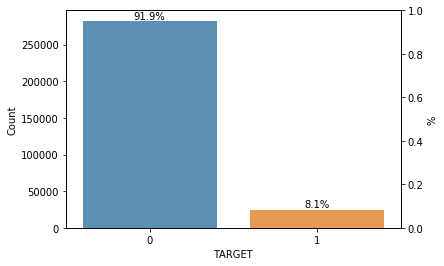

In [58]:
#sns.countplot(x='TARGET', data=df_application_train)
plot_counts(df_application_train, 'TARGET')
plt.show()

Majority of the clients do not have payment difficulties, so the TARGET variable is imbalanced.

In [7]:
# Drop any column that could pose potential discriminatory issues using in a model
# Gender, Family Status, Age, Area of Residence (Redlining), Type of Housing
cols2drop = ['CODE_GENDER', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 
             'DAYS_BIRTH', 'CNT_FAM_MEMBERS', 'REG_REGION_NOT_LIVE_REGION', 
             'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
             'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
             'LIVE_CITY_NOT_WORK_CITY', 'REGION_POPULATION_RELATIVE', 
             'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY','APARTMENTS_AVG',
             'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 
             'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
             'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
             'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
             'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE', 
             'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
             'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 
             'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 
             'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 
             'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
             'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 
             'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 
             'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
             'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
             # Columns to drop based on intuition
             'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 
             'FLAG_MOBIL', 'FLAG_EMP_PHONE' , 'FLAG_WORK_PHONE' ,'FLAG_CONT_MOBILE', 
             'FLAG_PHONE', 'FLAG_EMAIL', 'OWN_CAR_AGE',
             ]
df_application_train = df_application_train.drop(columns = cols2drop, axis = 1)

# Display top n records
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,N,Y,202500.0,406597.5,24700.5,351000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,35698.5,1129500.0,State servant,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,Y,Y,67500.0,135000.0,6750.0,135000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,N,Y,135000.0,312682.5,29686.5,297000.0,Working,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,N,Y,121500.0,513000.0,21865.5,513000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Review Categorical variables
df_application_train.describe(include='O')

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
count,307511,307511,307511,307511,307511,307511,211120,307511
unique,2,2,2,8,5,6,18,58
top,Cash loans,N,Y,Working,Secondary / secondary special,House / apartment,Laborers,Business Entity Type 3
freq,278232,202924,213312,158774,218391,272868,55186,67992


There are 8 categorical variables. We will look at distribution of TARGET based on categorial values.

bar l: [0, 1]
tick pos[0, 1]


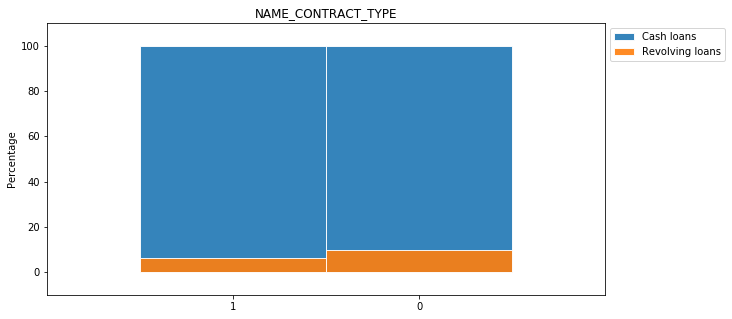

                       1        0
Cash loans       93.5388    90.21
Revolving loans  6.46123  9.79001
bar l: [0, 1]
tick pos[0, 1]


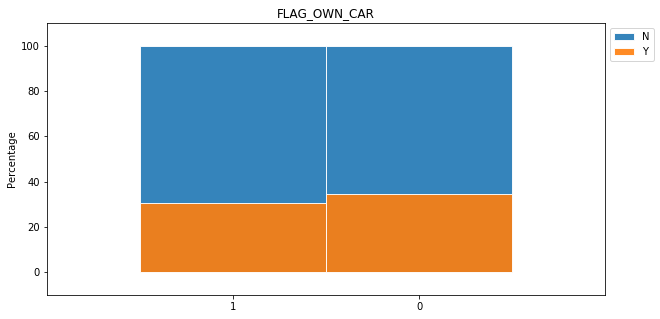

         1        0
N  69.4824  65.6824
Y  30.5176  34.3176
bar l: [0, 1]
tick pos[0, 1]


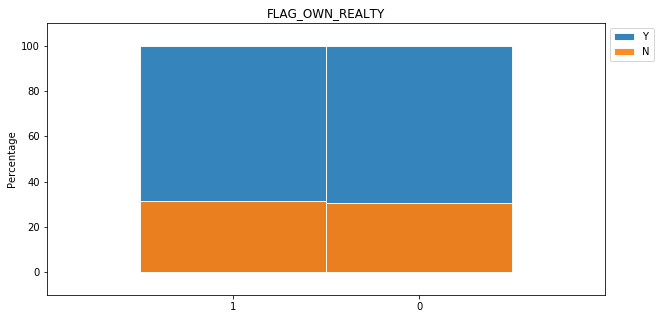

         1        0
Y  68.4109  69.4513
N  31.5891  30.5487
bar l: [0, 1]
tick pos[0, 1]


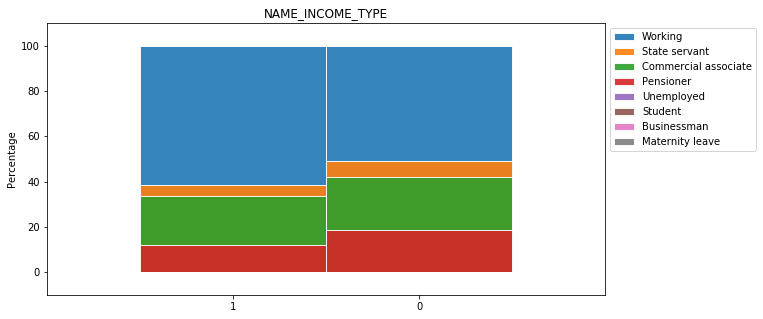

                               1           0
Working                  61.3253     50.7807
State servant            5.03122     7.23559
Commercial associate     21.5911     23.4384
Pensioner                12.0121     18.5294
Unemployed             0.0322256  0.00495249
Student                        0  0.00636749
Businessman                    0  0.00353749
Maternity leave       0.00805639  0.00106125
bar l: [0, 1]
tick pos[0, 1]


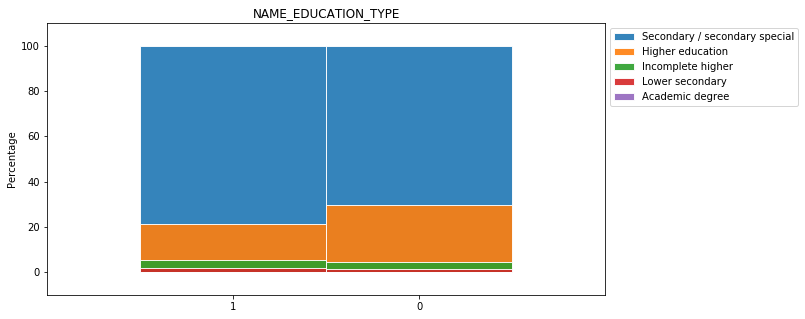

                                       1          0
Secondary / secondary special    78.6465    70.3491
Higher education                  16.149    25.0646
Incomplete higher                3.51259    3.32701
Lower secondary                  1.67976    1.20239
Academic degree                0.0120846  0.0569537
bar l: [0, 1]
tick pos[0, 1]


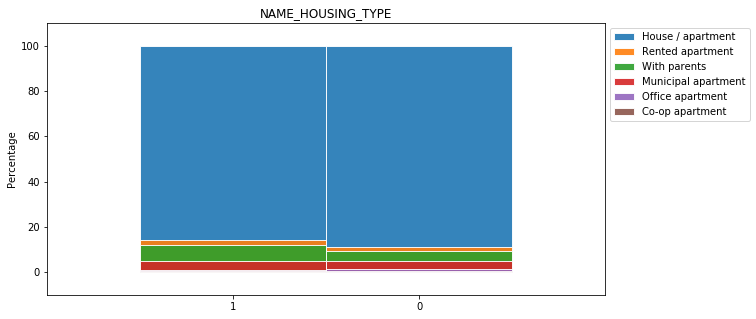

                           1         0
House / apartment    85.6878   89.0019
Rented apartment     2.42095   1.51405
With parents         6.99295   4.63553
Municipal apartment  3.84693   3.61815
Office apartment     0.69285  0.864917
Co-op apartment      0.35851  0.365423


In [131]:
categorical_features = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE']
for f in categorical_features:
    df_percentage = category_percentage_by_target(df_application_train, f, 'TARGET')
    plot_stacked_percentage_bar(df_percentage, f)
    print(df_percentage)

#### Look at distribution of numerical variables vs TARGET

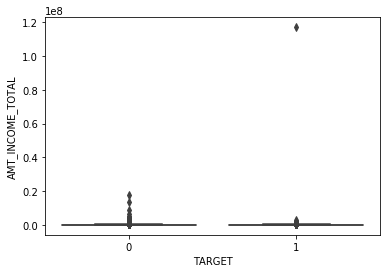

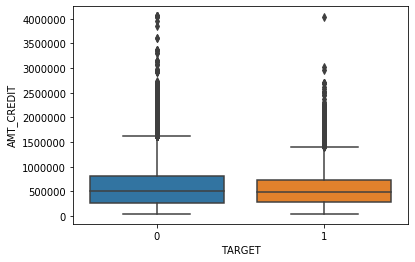

In [13]:
sns.boxplot(y='AMT_INCOME_TOTAL', x='TARGET', data=df_application_train)
plt.show()
sns.boxplot(y='AMT_CREDIT', x='TARGET', data=df_application_train)
plt.show()

#### Aggregate Bureau credit data

In [5]:
#Load the Application Train dataset
df_bureau = pd.read_csv(DATA_DIR + '/bureau.csv')

#Print Application Train dataset info
print(df_bureau.info())
print(df_bureau.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None
   SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464      

In [12]:
#Column to count all bureau records
df_bureau['BUREAU_COUNT'] = 1

# Bureau records within 30 days of application
df_bureau.loc[(df_bureau['DAYS_CREDIT'] <= 0) & (df_bureau['DAYS_CREDIT'] >= -30), 'BUREAU_COUNT_30'] = 1
# Bureau records within 31-60 days of application
df_bureau.loc[(df_bureau['DAYS_CREDIT'] <= -31) & (df_bureau['DAYS_CREDIT'] >= -60), 'BUREAU_COUNT_60'] = 1
# Bureau records within 61-120 days of application
df_bureau.loc[(df_bureau['DAYS_CREDIT'] <= -61) & (df_bureau['DAYS_CREDIT'] >= -120), 'BUREAU_COUNT_120'] = 1
# Bureau records >= 121 days of application
df_bureau.loc[(df_bureau['DAYS_CREDIT'] <= -121), 'BUREAU_COUNT_121_GT'] = 1

df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,...,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,BUREAU_COUNT,BUREAU_COUNT_30,BUREAU_COUNT_60,BUREAU_COUNT_120,BUREAU_COUNT_121_GT
0,215354,5714462,Closed,currency 1,0,-153.0,-153.0,NaN,0,91323.0,...,NaN,0.0,Consumer credit,-131,NaN,1,NaN,NaN,NaN,1.0
1,215354,5714463,Active,currency 1,0,1075.0,NaN,NaN,0,225000.0,...,NaN,0.0,Credit card,-20,NaN,1,NaN,NaN,NaN,1.0
2,215354,5714464,Active,currency 1,0,528.0,NaN,NaN,0,464323.5,...,NaN,0.0,Consumer credit,-16,NaN,1,NaN,NaN,NaN,1.0
3,215354,5714465,Active,currency 1,0,NaN,NaN,NaN,0,90000.0,...,NaN,0.0,Credit card,-16,NaN,1,NaN,NaN,NaN,1.0
4,215354,5714466,Active,currency 1,0,1197.0,NaN,77674.5,0,2700000.0,...,NaN,0.0,Consumer credit,-21,NaN,1,NaN,NaN,NaN,1.0


In [17]:
#bureau categorical features
bureau_categorical_features = ['CREDIT_ACTIVE', 'CREDIT_TYPE']

#convert categorical features to dummy columns
dummy = pd.get_dummies(df_bureau[bureau_categorical_features])

#Concat df_bureau and dummy
df_bureau = pd.concat([df_bureau, dummy], axis = 1)

print(df_bureau.head(1))

   SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  CREDIT_DAY_OVERDUE  \
0      215354       5714462        Closed      currency 1                   0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0               -153.0             -153.0                     NaN   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  ...  CREDIT_TYPE_Interbank credit  \
0                   0         91323.0  ...                             0   

   CREDIT_TYPE_Loan for business development  \
0                                          0   

   CREDIT_TYPE_Loan for purchase of shares (margin lending)  \
0                                                  0          

  CREDIT_TYPE_Loan for the purchase of equipment  \
0                                              0   

   CREDIT_TYPE_Loan for working capital replenishment  CREDIT_TYPE_Microloan  \
0                                                  0                       0   

   CREDIT_TYPE_Mobile operator loan  CREDIT_TYPE_Mortga

In [24]:
#get ACTIVE bureau accounts only
df_active_bureau = df_bureau[df_bureau['CREDIT_ACTIVE']=='Active'].copy()

#Standardize column names
rename_dict = dict()
for col in df_active_bureau.columns:
    rename_dict.update([(col, col.replace(' ','_').upper())])
df_active_bureau.rename(columns = rename_dict, inplace=True)

df_active_bureau.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630607 entries, 1 to 1716423
Data columns (total 40 columns):
SK_ID_CURR                                                  630607 non-null int64
SK_ID_BUREAU                                                630607 non-null int64
CREDIT_ACTIVE                                               630607 non-null object
CREDIT_CURRENCY                                             630607 non-null object
CREDIT_DAY_OVERDUE                                          630607 non-null int64
DAYS_CREDIT_ENDDATE                                         558111 non-null float64
DAYS_ENDDATE_FACT                                           1969 non-null float64
AMT_CREDIT_MAX_OVERDUE                                      218433 non-null float64
CNT_CREDIT_PROLONG                                          630607 non-null int64
AMT_CREDIT_SUM                                              630599 non-null float64
AMT_CREDIT_SUM_DEBT                                         

#### Do we need to keep all the columns?

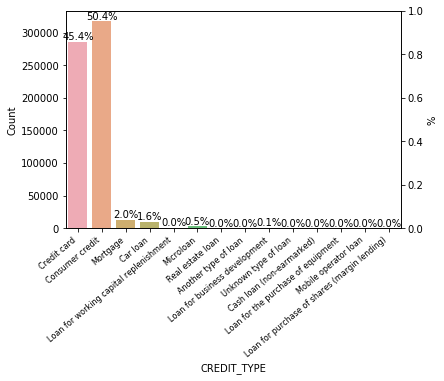

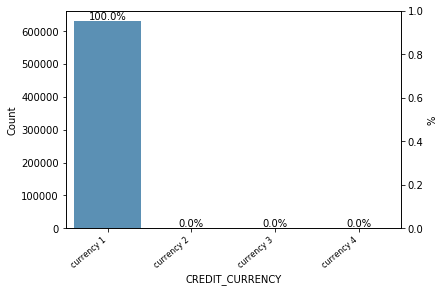

In [32]:
#Plot 2 categorical data in active accounts
plot_counts(df_active_bureau, 'CREDIT_TYPE')
plot_counts(df_active_bureau, 'CREDIT_CURRENCY')